<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Добавление-дополнительных-признаков" data-toc-modified-id="Добавление-дополнительных-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Добавление дополнительных признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужна модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим данные и выполним их ресемплирование по одному часу.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ моделей

Посмотрим на данные в динамике

Text(0.5, 1.0, 'Количество заказов такси по часам')

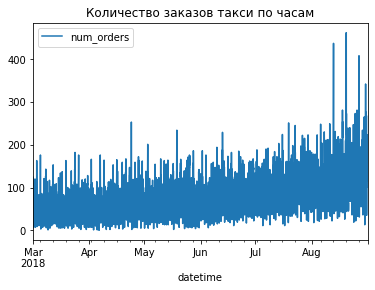

In [2]:
data.plot()
plt.title('Количество заказов такси по часам')

В данных довольно много шума. Он мешает делать выводы.
Попробуем сгладить выбросы с помощью скльзащего среднего

Text(0.5, 1.0, 'Количество заказов такси по часам - скользящее среднее')

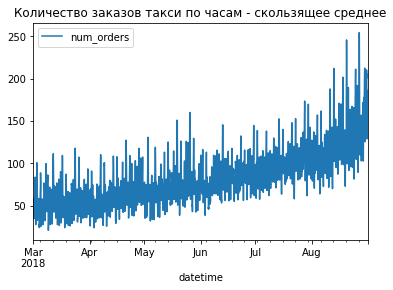

In [3]:
data.rolling(7).mean().plot()
plt.title('Количество заказов такси по часам - скользящее среднее')

Ок, мы видим, что количество заказов растет с течением времени. Видимо, сервис становится популярнее. 

Сезонность анализировать бессмысленно - при текущем масштабе данных суточные/недельные колебания будут незаметны, а месяцы у нас не повторяются

Убедимся в этом с помощью инструмента seasonal_decompose:

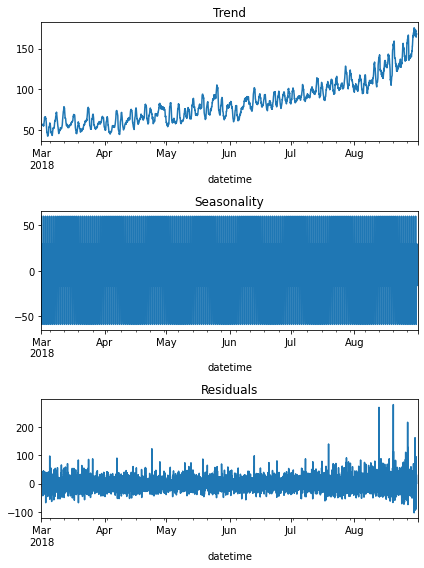

In [4]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Что и ребовалось доказать: виден восходящий тренд числа заказов с течением времени и отсутствие сезонности в почасовых данных в течение полугода

## Добавление дополнительных признаков

Выделим в качестве признаков год, месяц, день, день недели и час заказа

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [6]:
data = make_features(data, 5, 1)

In [7]:
print (data['year'].min())
print (data['year'].max())

2018
2018


Ок, у нас данные за один год, можно удалить столбец ввиду неинформативности

In [8]:
data = data.drop('year',axis = 1)

Посмотрим на получившиеся данные

In [9]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,71.0
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,66.0


## Обучение

Подготовим обучающую и тестовую выборки

In [10]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders',axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders',axis = 1)
target_test = test['num_orders']

Обучим несколько моделей: линейную регрессию, randomforest, дерево решений и CatBoostRegressor

In [11]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(features_train, target_train)

LinearRegression()

In [12]:
tscv = TimeSeriesSplit(n_splits=5) # Взяли стандартное значение количества разбиений, чтобы модель не переобучалась

In [13]:
parametrs = {'n_estimators': range (60, 150, 10), 'max_depth':range (15, 21, 2)}
grid = GridSearchCV(RandomForestRegressor(random_state=12345), parametrs, scoring='neg_root_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(15, 21, 2),
                         'n_estimators': range(60, 150, 10)},
             scoring='neg_root_mean_squared_error')

In [14]:
grid.best_params_

{'max_depth': 19, 'n_estimators': 130}

In [15]:
model_random_f = RandomForestRegressor(random_state=12345,max_depth = 19, n_estimators = 130)
model_random_f.fit(features_train, target_train)

RandomForestRegressor(max_depth=19, n_estimators=130, random_state=12345)

In [16]:
parametrs = {'max_depth':range (1, 10, 1)}
grid = GridSearchCV(DecisionTreeRegressor(random_state=12345), parametrs, scoring='neg_root_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10)},
             scoring='neg_root_mean_squared_error')

In [17]:
grid.best_params_

{'max_depth': 8}

In [18]:
model_decision_t = DecisionTreeRegressor(random_state=12345,max_depth = 8)
model_decision_t.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=8, random_state=12345)

In [19]:
parametrs = {'n_estimators': range (130, 141, 1)}
grid = GridSearchCV(CatBoostRegressor(random_state=12345), parametrs, scoring='neg_root_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)

Learning rate set to 0.201579
0:	learn: 27.0216523	total: 47.2ms	remaining: 6.08s
1:	learn: 25.0340051	total: 48.2ms	remaining: 3.08s
2:	learn: 23.3750532	total: 49.1ms	remaining: 2.08s
3:	learn: 21.8489830	total: 49.9ms	remaining: 1.57s
4:	learn: 20.9382842	total: 51ms	remaining: 1.27s
5:	learn: 20.3596202	total: 52ms	remaining: 1.07s
6:	learn: 19.8727009	total: 52.8ms	remaining: 928ms
7:	learn: 19.2399870	total: 53.6ms	remaining: 818ms
8:	learn: 18.7054648	total: 54.5ms	remaining: 732ms
9:	learn: 18.2509805	total: 55.3ms	remaining: 664ms
10:	learn: 17.8187353	total: 56.1ms	remaining: 607ms
11:	learn: 17.5288151	total: 57ms	remaining: 561ms
12:	learn: 17.2200429	total: 57.8ms	remaining: 521ms
13:	learn: 17.0763732	total: 58.6ms	remaining: 486ms
14:	learn: 16.8093007	total: 59.5ms	remaining: 456ms
15:	learn: 16.6504580	total: 60.3ms	remaining: 430ms
16:	learn: 16.4486051	total: 61.2ms	remaining: 407ms
17:	learn: 16.2788042	total: 61.9ms	remaining: 385ms
18:	learn: 16.0648402	total: 62.

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc08b01df70>,
             param_grid={'n_estimators': range(130, 141)},
             scoring='neg_root_mean_squared_error')

In [20]:
grid.best_params_

{'n_estimators': 139}

In [21]:
model_cat = CatBoostRegressor(random_state=12345,loss_function="RMSE", iterations=139)
model_cat.fit(features_train, target_train)

Learning rate set to 0.253221
0:	learn: 35.0291600	total: 2.27ms	remaining: 313ms
1:	learn: 32.1738420	total: 4.23ms	remaining: 290ms
2:	learn: 30.2766668	total: 6.02ms	remaining: 273ms
3:	learn: 29.1841234	total: 7.8ms	remaining: 263ms
4:	learn: 28.1977619	total: 9.5ms	remaining: 255ms
5:	learn: 27.6390391	total: 11.2ms	remaining: 248ms
6:	learn: 27.2700425	total: 12.9ms	remaining: 242ms
7:	learn: 26.6585964	total: 14.5ms	remaining: 237ms
8:	learn: 26.4585720	total: 16.1ms	remaining: 233ms
9:	learn: 26.1989552	total: 17.7ms	remaining: 229ms
10:	learn: 26.1548075	total: 19.3ms	remaining: 225ms
11:	learn: 25.9974314	total: 20.9ms	remaining: 221ms
12:	learn: 25.8509504	total: 22.4ms	remaining: 217ms
13:	learn: 25.7675604	total: 24ms	remaining: 214ms
14:	learn: 25.3280695	total: 25.6ms	remaining: 211ms
15:	learn: 24.8778011	total: 27.2ms	remaining: 209ms
16:	learn: 24.7407740	total: 28.8ms	remaining: 207ms
17:	learn: 24.5009447	total: 30.5ms	remaining: 205ms
18:	learn: 24.2449890	total: 3

Сравним значения RMSE моделей на обучающей выборке.

In [22]:
print("RMSE обучающей выборки LinearRegression:", mean_squared_error(target_train,model_lin_reg.predict(features_train))**0.5)
print("RMSE обучающей выборки RandomForestRegressor:", mean_squared_error(target_train,model_random_f.predict(features_train))**0.5)
print("RMSE обучающей выборки DecisionTreeRegressor:", mean_squared_error(target_train,model_decision_t.predict(features_train))**0.5)
print("RMSE обучающей выборки CatBoostRegressor:", mean_squared_error(target_train,model_cat.predict(features_train))**0.5)

RMSE обучающей выборки LinearRegression: 31.62646196671147
RMSE обучающей выборки RandomForestRegressor: 9.105038710073563
RMSE обучающей выборки DecisionTreeRegressor: 21.930223032758363
RMSE обучающей выборки CatBoostRegressor: 17.209834898289447


## Тестирование

Проверим работу модели с лучшим результатом на тестовой выборке

In [23]:
print("RMSE тестовой выборки RandomForestRegressor: ", mean_squared_error(target_test,model_random_f.predict(features_test))**0.5)

RMSE тестовой выборки RandomForestRegressor:  52.579072881901936


Результат хуже целевого, проверим другую модель.

In [24]:
print("RMSE тестовой выборки CatBoostRegressor: ", mean_squared_error(target_test,model_cat.predict(features_test))**0.5)

RMSE тестовой выборки CatBoostRegressor:  47.49187004889193


Результат данной модели подходит - примем ее за решение задачи.

In [43]:
predictions = pd.DataFrame(model_cat.predict(features_test), index = target_test.index)

In [48]:
#predictions = predictions.rename(columns={"0": "predictions"}) #не работает :/

Text(0.5, 1.0, 'Сравнение результата модели и целевой функции')

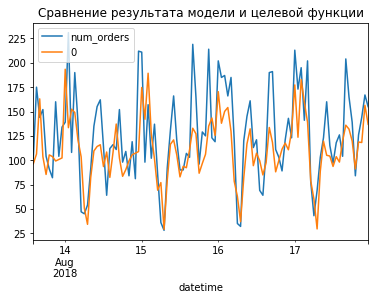

In [47]:
target_test.to_frame().join(predictions)['2018-08-13':'2018-08-17'].plot()
plt.title('Сравнение результата модели и целевой функции')

# Вывод

Итог:
- Мы загрузили данные - в материале предоставлены только время и количество заказов.
- Агрегировали заказы по каждому часу, в качестве признаков выделили день недели, час заказа  и др
- Подготовили выборки - обучающая составила 90% от всех данных (по условию задачи)
- Обучили и протестировали на обеих выборках несколько моделей - линейную регрессию, случайный лес, дерево решений и CatBoostRegressor
- Лучший результат на тестовой выборке показала модель CatBoostRegressor с 139 итерациями: RMSE тестовой выборки CatBoostRegressor:  47.5 (целевое значение RMSE - 48) 